<a href="https://colab.research.google.com/github/VladimirBoshnjakovski/explainable-ai-thesis-code/blob/main/06_xai_shap_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ──────────────── IMPORTS ────────────────
import pandas as pd
import numpy as np
import shap
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers, optimizers
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
# Upload the dataset file from your computer
uploaded = files.upload()

# Read the CSV file into a DataFrame
df = pd.read_csv(next(iter(uploaded)))

# ──────────────── PREPROCESS ────────────────
# Assume df already loaded
df = df.drop(columns=['source']) \
       .rename(columns={'Presence of Heart Disease (1=Yes)': 'target'})

Saving heart_hotwired.csv to heart_hotwired.csv


In [ ]:
X = df.drop(columns=['target']).values
y = df['target'].values

# stratified train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [ ]:
# ──────────────── MODEL BUILDER ────────────────
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers, optimizers

def build_model(input_dim):
    l2 = regularizers.l2(1e-4)
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', kernel_regularizer=l2),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=l2),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=l2),
        layers.Dense(1, activation='sigmoid')
    ])

    # lower learning rate, track AUC
    opt = optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

model = build_model(X_train.shape[1])

# ──────────────── CALLBACKS ────────────────
es = callbacks.EarlyStopping(
    monitor='val_auc',      # stop when AUC stops improving
    mode='max',             # we want to MAXIMIZE AUC
    patience=10,
    restore_best_weights=True
)

rlr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

# ──────────────── TRAIN ────────────────
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[es, rlr],
    verbose=2
)

# ──────────────── EVALUATE ────────────────
loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss:.4f}   |   Test accuracy: {acc:.4f}   |   Test AUC: {auc:.4f}")

Epoch 1/100
52/52 - 3s - 53ms/step - accuracy: 0.6012 - auc: 0.6142 - loss: 0.6976 - val_accuracy: 0.7308 - val_auc: 0.8277 - val_loss: 0.5728 - learning_rate: 1.0000e-03
Epoch 2/100
52/52 - 1s - 15ms/step - accuracy: 0.7446 - auc: 0.8101 - loss: 0.5464 - val_accuracy: 0.7885 - val_auc: 0.8850 - val_loss: 0.4671 - learning_rate: 1.0000e-03
Epoch 3/100
52/52 - 0s - 6ms/step - accuracy: 0.7831 - auc: 0.8546 - loss: 0.4802 - val_accuracy: 0.8269 - val_auc: 0.8948 - val_loss: 0.4146 - learning_rate: 1.0000e-03
Epoch 4/100
52/52 - 0s - 5ms/step - accuracy: 0.7928 - auc: 0.8714 - loss: 0.4510 - val_accuracy: 0.8269 - val_auc: 0.9033 - val_loss: 0.3951 - learning_rate: 1.0000e-03
Epoch 5/100
52/52 - 0s - 5ms/step - accuracy: 0.8229 - auc: 0.8866 - loss: 0.4235 - val_accuracy: 0.8413 - val_auc: 0.9129 - val_loss: 0.3743 - learning_rate: 1.0000e-03
Epoch 6/100
52/52 - 0s - 4ms/step - accuracy: 0.8422 - auc: 0.9124 - loss: 0.3838 - val_accuracy: 0.8558 - val_auc: 0.9158 - val_loss: 0.3574 - lear

In [ ]:
# ──────────────── SHAP LOCAL INTERPRETATIONS ────────────────
import shap
import time

# Initialize the SHAP explainer
explainer = shap.KernelExplainer(model.predict, X_train)

# Instance to explain (instance 40 from the test set)
instance_idx = 40
x_instance = X_test[instance_idx].reshape(1, -1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
import pandas as pd
import time
import shap
import matplotlib.pyplot as plt

# Assuming explainer is already initialized and x_instance is defined
shap_values_list = []
time_taken_list = []

# Run SHAP local interpretation 3 times and calculate the time taken for each
for i in range(5):
    start_time = time.time()
    shap_values = explainer.shap_values(x_instance)
    end_time = time.time()

    shap_values_list.append(shap_values)
    time_taken_list.append(end_time - start_time)



  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 86s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 84s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 88s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 83s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 84s 1ms/step


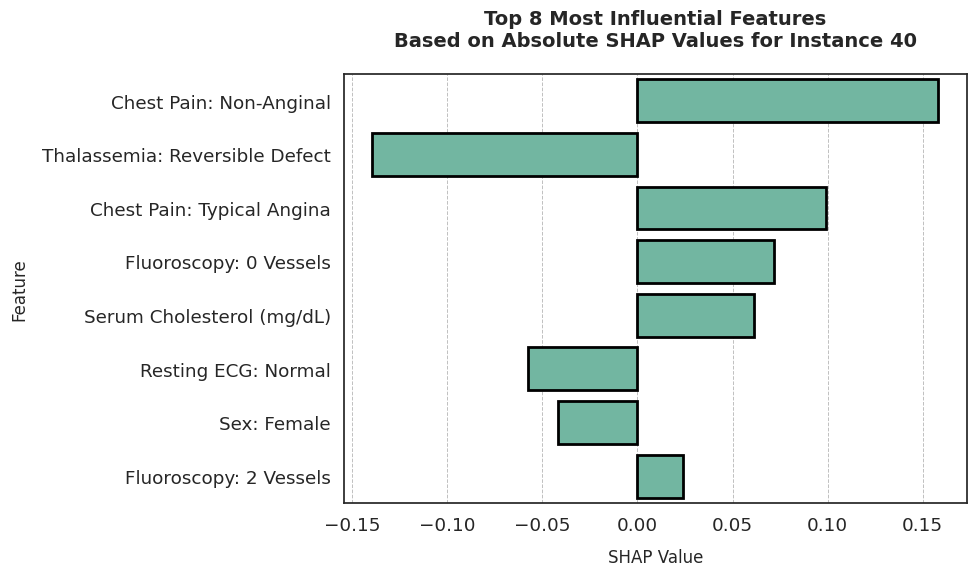

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example for a specific instance (let's assume instance index 40 as an example)
instance_idx = 40
shap_values = shap_values_list[0]  # Treating this as an example (first run)

# Flatten the SHAP values from the run
shap_values_flat = shap_values[0].flatten()

# Get the feature names from your dataset
feature_names = df.drop(columns=['target']).columns.tolist()

# Create a DataFrame to map SHAP values to feature names
shap_values_df = pd.DataFrame(shap_values_flat, columns=["SHAP Value"])
shap_values_df["Feature"] = feature_names  # Link feature names to SHAP values

# Compute the absolute value for sorting
shap_values_df["abs_SHAP Value"] = shap_values_df["SHAP Value"].abs()

# Sort the DataFrame by absolute SHAP Value in descending order
shap_values_df = shap_values_df.sort_values(by="abs_SHAP Value", ascending=False)

# Select top 8 features with the highest absolute SHAP values
top_features = shap_values_df.head(8)

# Set a sketch-like style with Seaborn
sns.set(style="white", palette="muted", font_scale=1.2)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot using Seaborn's barplot with coloring based on the "Set2" color palette
sns.barplot(x="SHAP Value", y="Feature", data=top_features, color=sns.color_palette("Set2", n_colors=1)[0], edgecolor='black', linewidth=2)

# Add gridlines for a "net" effect
plt.grid(True, axis='x', linestyle='--', linewidth=0.7, color='gray', alpha=0.5)

# Set labels and title with a bit more padding and font size
plt.xlabel('SHAP Value', fontsize=12, labelpad=10)
plt.ylabel('Feature', fontsize=12, labelpad=10)

# Title in two lines with bold font
plt.title(f'Top 8 Most Influential Features\nBased on Absolute SHAP Values for Instance {instance_idx}', fontsize=14, fontweight='bold', pad=20)

# Adjust the layout to avoid clipping the labels
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import shap
import numpy as np

shap.initjs()

# Instance to explain
instance_index = 40
x_instance_raw = X_test[instance_index].reshape(1, -1)

# Recompute SHAP values
shap_values = explainer.shap_values(x_instance_raw)

# Flatten
shap_value_instance = shap_values[0].flatten()
x_instance = x_instance_raw.flatten()
feature_names = df.drop(columns='target').columns.tolist()

# Top 8
top8_indices = np.argsort(np.abs(shap_value_instance))[::-1][:8]
shap_top8 = shap_value_instance[top8_indices]
x_top8 = x_instance[top8_indices]
feature_names_top8 = [feature_names[i] for i in top8_indices]
x_top8_2D = x_top8.reshape(1, -1)



  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 91s 1ms/step


In [ ]:
# Flatten
shap_value_instance = shap_values[0].flatten()
x_instance = x_instance_raw.flatten()
feature_names = df.drop(columns='target').columns.tolist()

# Top 8
top8_indices = np.argsort(np.abs(shap_value_instance))[::-1][:8]
shap_top8 = shap_value_instance[top8_indices]
x_top8 = x_instance[top8_indices]
feature_names_top8 = [feature_names[i] for i in top8_indices]
x_top8_2D = x_top8.reshape(1, -1)

# Display in notebook
shap_plot = shap.force_plot(
    base_value     = explainer.expected_value[0],
    shap_values    = shap_top8,
    features       = x_top8_2D,
    feature_names  = feature_names_top8
)

# Show + Save to HTML
shap_plot
shap.save_html("shap_forceplot_instance_40.html", shap_plot)

In [ ]:
force_plot = shap.force_plot(
    base_value     = explainer.expected_value[0],
    shap_values    = shap_top8,
    features       = x_top8_2D,
    feature_names  = feature_names_top8
)


In [ ]:
# Save and trigger download
shap.save_html("shap_force_plot_instance40.html", force_plot)
files.download("shap_force_plot_instance40.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shap
import numpy as np

# Activate JS-based plotting
shap.initjs()

# Step 1: Choose instance to explain
instance_index = 30
x_instance_raw = X_test[instance_index].reshape(1, -1)      # shape: (1, n_features)

# Step 2: Recompute SHAP values for this instance
shap_values = explainer.shap_values(x_instance_raw)         # shape: (1, n_features, 1)

# Step 3: Flatten SHAP values and input features
shap_value_instance = shap_values[0].flatten()              # shape: (n_features,)
x_instance = x_instance_raw.flatten()                       # shape: (n_features,)
feature_names = df.drop(columns='target').columns.tolist()  # list of feature names

# Step 4: Get top 8 features by absolute SHAP value
top8_indices = np.argsort(np.abs(shap_value_instance))[::-1][:8]
shap_top8 = shap_value_instance[top8_indices]
x_top8 = x_instance[top8_indices]
feature_names_top8 = [feature_names[i] for i in top8_indices]

# Step 5: Reshape input features for SHAP
x_top8_2D = x_top8.reshape(1, -1)

# Step 6: Plot SHAP force plot
print(f"🔍 SHAP Force Plot – Instance #{instance_index}")
shap.force_plot(
    base_value     = explainer.expected_value[0],
    shap_values    = shap_top8,
    features       = x_top8_2D,
    feature_names  = feature_names_top8
)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
47402/68249 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step

KeyboardInterrupt: 

In [ ]:
import shap
import numpy as np

# Activate JS-based plotting
shap.initjs()

# Step 1: Choose instance to explain
instance_index = 50
x_instance_raw = X_test[instance_index].reshape(1, -1)      # shape: (1, n_features)

# Step 2: Recompute SHAP values for this instance
shap_values = explainer.shap_values(x_instance_raw)         # shape: (1, n_features, 1)

# Step 3: Flatten SHAP values and input features
shap_value_instance = shap_values[0].flatten()              # shape: (n_features,)
x_instance = x_instance_raw.flatten()                       # shape: (n_features,)
feature_names = df.drop(columns='target').columns.tolist()  # list of feature names

# Step 4: Get top 8 features by absolute SHAP value
top8_indices = np.argsort(np.abs(shap_value_instance))[::-1][:8]
shap_top8 = shap_value_instance[top8_indices]
x_top8 = x_instance[top8_indices]
feature_names_top8 = [feature_names[i] for i in top8_indices]

# Step 5: Reshape input features for SHAP
x_top8_2D = x_top8.reshape(1, -1)

# Step 6: Plot SHAP force plot
print(f"🔍 SHAP Force Plot – Instance #{instance_index}")
shap.force_plot(
    base_value     = explainer.expected_value[0],
    shap_values    = shap_top8,
    features       = x_top8_2D,
    feature_names  = feature_names_top8
)


In [ ]:
import shap
import numpy as np
shap.initjs()

# Step 1: Flatten SHAP values (shape: (28,))
shap_value_instance = shap_values[0].flatten()

# Step 2: Get feature names and feature values
feature_names = df.drop(columns='target').columns.tolist()
x_instance = X_test[0].reshape(-1)  # 1D array of 28 features

# Step 3: Get top 8 feature indices by absolute SHAP value
top8_indices = np.argsort(np.abs(shap_value_instance))[::-1][:8]

# Step 4: Subset SHAP values, feature values, and names
shap_top8 = shap_value_instance[top8_indices]
x_top8 = x_instance[top8_indices]
feature_names_top8 = [feature_names[i] for i in top8_indices]

# Step 5: Reshape feature vector for SHAP input (shape: (1, 8))
x_top8_2D = x_top8.reshape(1, -1)

# Step 6: Plot
shap.force_plot(
    base_value     = explainer.expected_value[0],
    shap_values    = shap_top8,
    features       = x_top8_2D,
    feature_names  = feature_names_top8
)


/tmp/ipython-input-8-2002048347.py:37: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(x="SHAP Value", y="Feature", hue="Run", data=combined_shap_values, dodge=True,


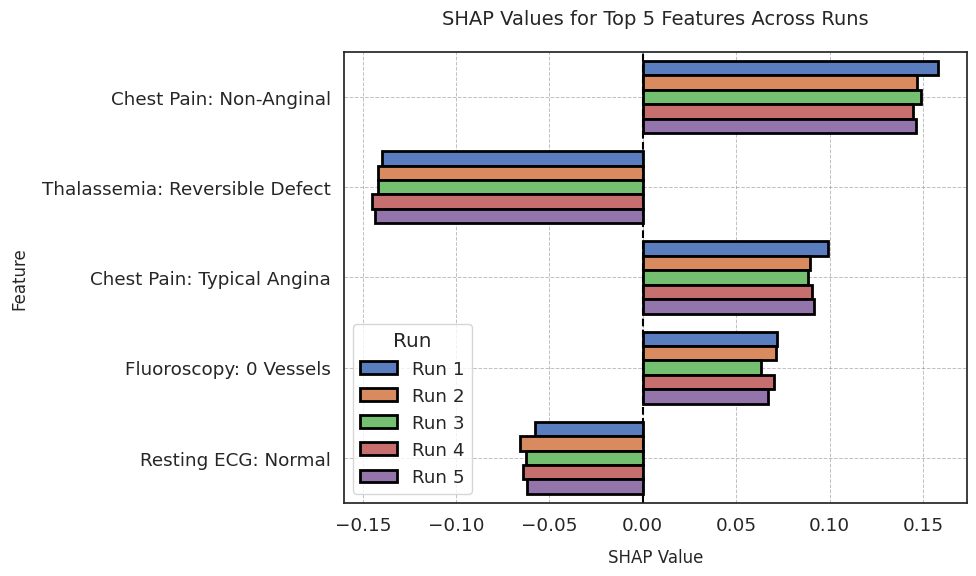

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Process each SHAP value for each run
shap_values_df_list = []

for shap_values in shap_values_list:
    shap_values_flat = shap_values[0].flatten()  # Flatten SHAP values

    # Create DataFrame
    shap_values_df = pd.DataFrame(shap_values_flat, columns=["SHAP Value"])
    shap_values_df["Feature"] = feature_names  # Link feature names to SHAP values
    shap_values_df["abs_SHAP Value"] = shap_values_df["SHAP Value"].abs()  # Absolute value for sorting

    shap_values_df_list.append(shap_values_df)

# Combine the SHAP values from all runs into one DataFrame
combined_shap_values = pd.concat([df.set_index("Feature")["SHAP Value"] for df in shap_values_df_list], axis=1)
combined_shap_values.columns = [f"Run {i+1}" for i in range(len(shap_values_df_list))]

# Sort the values based on the absolute value of SHAP values and select the top 5 features
combined_shap_values = combined_shap_values.reindex(combined_shap_values.abs().max(axis=1).sort_values(ascending=False).index).head(5)

# Reshape the data to be suitable for Seaborn
combined_shap_values = combined_shap_values.reset_index()
combined_shap_values = pd.melt(combined_shap_values, id_vars="Feature", var_name="Run", value_name="SHAP Value")

# Set a sketch-like style
sns.set(style="white", palette="muted", font_scale=1.2)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot using Seaborn's barplot with a "sketch" theme
sns.barplot(x="SHAP Value", y="Feature", hue="Run", data=combined_shap_values, dodge=True,
            edgecolor='black', linewidth=2, capsize=5, errwidth=2)

# Add a vertical line at zero
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5)

# Add gridlines for the "net" effect (background grid)
plt.grid(True, linestyle='--', linewidth=0.7, color='gray', alpha=0.5)

# Set labels and title with a bit more padding and font size
plt.xlabel('SHAP Value', fontsize=12, labelpad=10)
plt.ylabel('Feature', fontsize=12, labelpad=10)
plt.title('SHAP Values for Top 5 Features Across Runs', fontsize=14, pad=20)

# Adjust the layout to avoid clipping the labels
plt.tight_layout()

# Show the plot
plt.show()


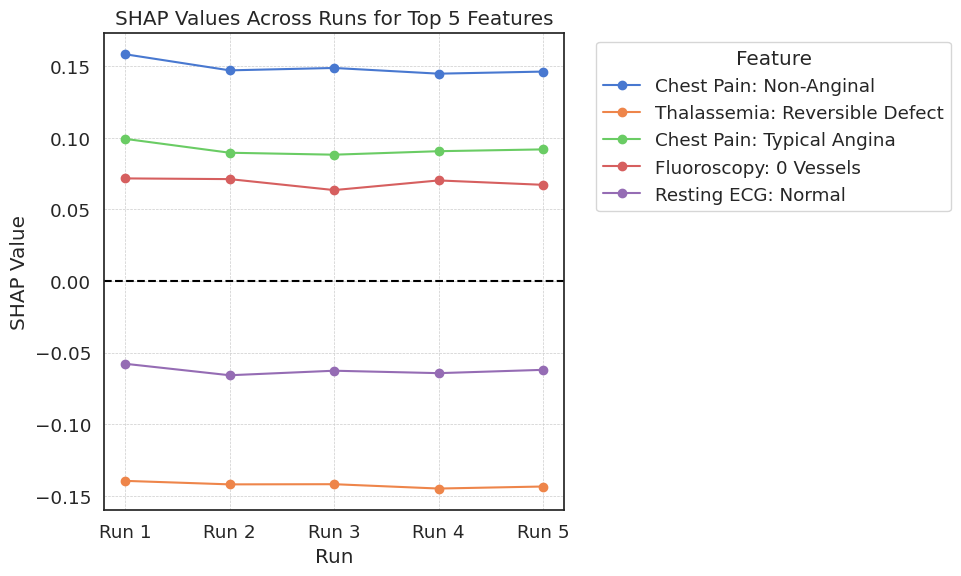

In [ ]:
plt.figure(figsize=(10, 6))
for feature in combined_shap_values["Feature"].unique():
    subset = combined_shap_values[combined_shap_values["Feature"] == feature]
    plt.plot(subset["Run"], subset["SHAP Value"], marker='o', label=feature)

plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Run")
plt.ylabel("SHAP Value")
plt.title("SHAP Values Across Runs for Top 5 Features")
plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()


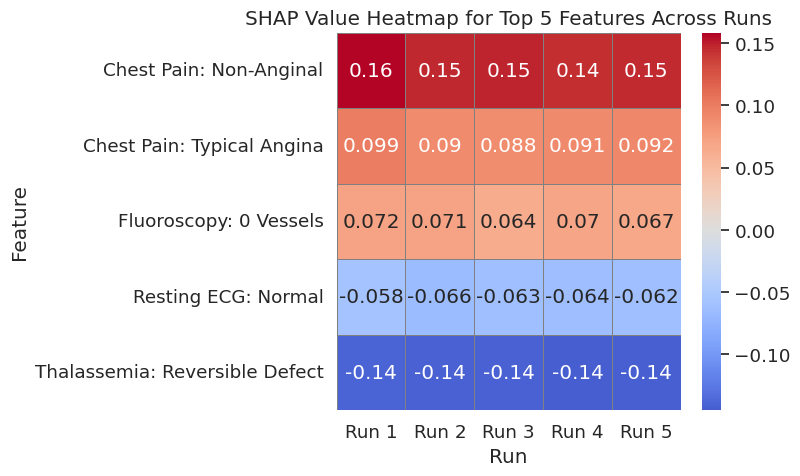

In [ ]:
pivot = combined_shap_values.pivot(index="Feature", columns="Run", values="SHAP Value")
plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, cmap="coolwarm", center=0, linewidths=0.5, linecolor='gray')
plt.title("SHAP Value Heatmap for Top 5 Features Across Runs")
plt.tight_layout()
plt.show()


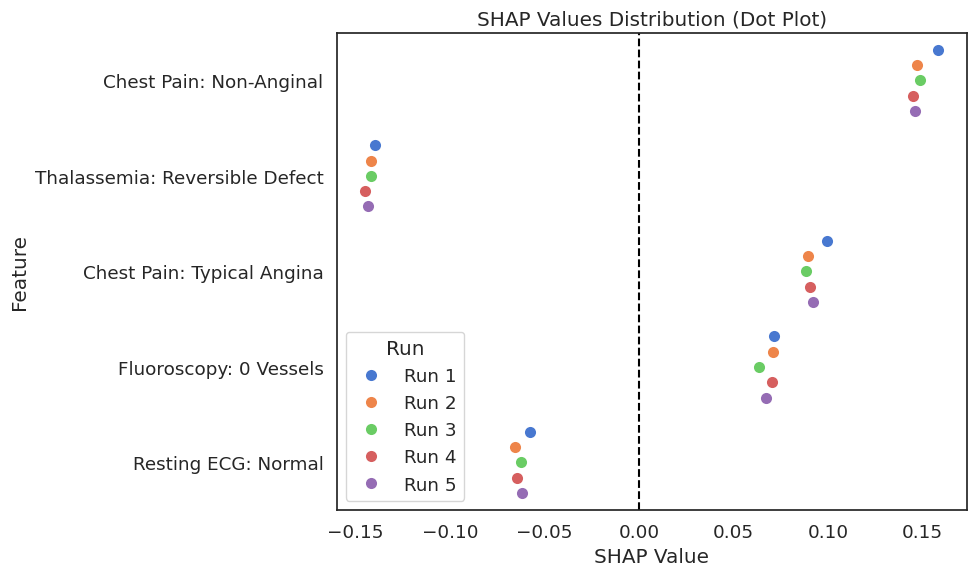

In [ ]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=combined_shap_values, x="SHAP Value", y="Feature", hue="Run", jitter=True, dodge=True, size=8)
plt.axvline(0, color='black', linestyle='--')
plt.title("SHAP Values Distribution (Dot Plot)")
plt.tight_layout()
plt.show()


/tmp/ipython-input-13-269092515.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="SHAP Value", y="Feature", data=std_dev_df, palette="OrRd")


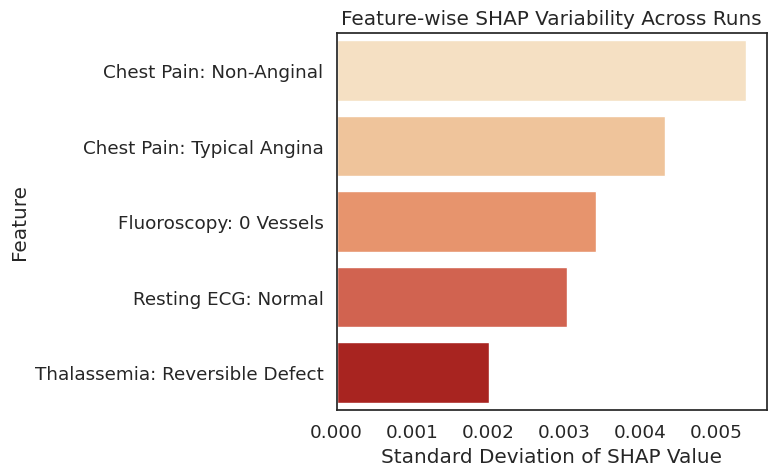

In [ ]:
std_dev_df = combined_shap_values.groupby("Feature")["SHAP Value"].std().sort_values(ascending=False).reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x="SHAP Value", y="Feature", data=std_dev_df, palette="OrRd")
plt.xlabel("Standard Deviation of SHAP Value")
plt.title("Feature-wise SHAP Variability Across Runs")
plt.tight_layout()
plt.show()
